<a href="https://colab.research.google.com/github/dohyun-kim92/TIL/blob/master/bok_pol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import package
import pandas as pd
import numpy as np
import itertools
import nltk
import requests
import csv
import math
import json
import copy
from bs4 import BeautifulSoup
import pandas as pd
import datetime
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB


# from sklearn.data

In [ ]:
df = pd.read_json(r"C:\Users\dhsmi\Downloads\nn.json")
df.drop(['rate'], axis = 1 ,inplace = True)
df.reset_index(drop=True, inplace=True)
df

,date,ngram,ud
0,2005-05-01,"수입/NNG;증대/NNG,실적/NNG;높/VV,하락/NNG,위험/NNG,자신/NNG",-1
1,2005-05-01,"기업/NNG;수익성/NNG;악화/NNG;우려/NNG,경제/NNG;지표/NNG;성장/...",-1
2,2005-05-01,"인플레이션/NNG;압력/NNG;억제/NNG,금리/NNG;인상/NNG;긴축/NNG,지...",-1
3,2005-05-01,"대출/NNG;연체율/NNG;오르/VV,대출/NNG;연체율/NNG;높/VA,대출심사/...",-1
4,2005-05-01,"무수익여신/NNG;증가/NNG,수익성/NNG;악화/NNG,악화/NNG;조짐/NNG,...",-1
...,...,...,...
291601,2020-06-03,"대부업/NNG;고금리/NNG,최대/NNG",1
291602,2020-06-03,"매출/NNG;감소/NNG,금리/NNG;낮/VA,타격/NNG,최저/NNG,최대/NNG",1
291603,2020-06-03,"안정/NNG,유예/NNG,최대/NNG",1
291604,2020-06-03,"금융채/NNG;발행/NNG;급증/NNG,금리/NNG;비교/NNG;낮/VA",1


In [ ]:
df

,date,ngram,ud
0,2005-05-01,"수입/NNG;증대/NNG,실적/NNG;높/VV,하락/NNG,위험/NNG,자신/NNG",-1
1,2005-05-01,"기업/NNG;수익성/NNG;악화/NNG;우려/NNG,경제/NNG;지표/NNG;성장/...",-1
2,2005-05-01,"인플레이션/NNG;압력/NNG;억제/NNG,금리/NNG;인상/NNG;긴축/NNG,지...",-1
3,2005-05-01,"대출/NNG;연체율/NNG;오르/VV,대출/NNG;연체율/NNG;높/VA,대출심사/...",-1
4,2005-05-01,"무수익여신/NNG;증가/NNG,수익성/NNG;악화/NNG,악화/NNG;조짐/NNG,...",-1
...,...,...,...
291601,2020-06-03,"대부업/NNG;고금리/NNG,최대/NNG",1
291602,2020-06-03,"매출/NNG;감소/NNG,금리/NNG;낮/VA,타격/NNG,최저/NNG,최대/NNG",1
291603,2020-06-03,"안정/NNG,유예/NNG,최대/NNG",1
291604,2020-06-03,"금융채/NNG;발행/NNG;급증/NNG,금리/NNG;비교/NNG;낮/VA",1


In [ ]:
class NBC():
    def add_data(self, datas):
        word_column = datas.columns[1]
        target_column = datas.columns[2]
        target_ls = list(set(datas[target_column]))
        datas[word_column] = list(map(lambda i : i.split(','), datas[word_column]))
        total_ngram = list(itertools.chain(*list(datas[word_column]))) # list로 들어가지 않을 경우
        unique_ngram = list(set(total_ngram))
        result_df = pd.DataFrame(unique_ngram, columns = [word_column]).set_index(word_column)
        for target in target_ls:
            this_ngram = list(itertools.chain(*list(datas[datas[target_column] == target][word_column])))
            fdist = nltk.FreqDist(this_ngram)
            temp_df = pd.DataFrame(list(zip(fdist.keys(), fdist.values())), columns= [word_column, 'count']).set_index(word_column)
            result_df[target] = temp_df['count']
            
        result_df.fillna(0, inplace=True)
        result_df['score'] = 0
        self.df = copy.deepcopy(result_df)
        return self.df
    
    def count_vec(self, datas):
        word_column = datas.columns[0]
        target_column = datas.columns[1]
        target_ls = list(set(datas[target_column]))

        total_ngram = list(itertools.chain(*list(datas[word_column]))) 
        unique_ngram = list(set(total_ngram))
        result_df = pd.DataFrame(unique_ngram, columns = [word_column]).set_index(word_column)
        
        for target in target_ls:
            this_ngram = list(itertools.chain(*list(datas[datas[target_column] == target][word_column])))
            fdist = nltk.FreqDist(this_ngram)
            temp_df = pd.DataFrame(list(zip(fdist.keys(), fdist.values())), columns= [word_column, 'count']).set_index(word_column)
            result_df[target] = temp_df['count']

        result_df.fillna(0, inplace=True)
        return result_df
    
    def polarity_score(self, datas):
        df = datas
        
        df['haw'] = df[1] / sum(df[1])
        df['dov'] = df[-1] / sum(df[-1])
        self.df['score'] += df['haw'] / df['dov']
        return self.df

    def bagging(self, train_data, k):
        for i in range(k):
            self.polarity_score(self.count_vec(train_data.sample(frac=0.9)))
        self.df['score'] = self.df['score'] / k
        return self.df

In [ ]:
nbc=NBC()
nbc.add_data(df)

,0,1,-1,score
ngram,,,,
부양책/NNG;약화/NNG,3.0,1.0,8.0,0
국채입찰/NNG;낙찰/NNG;금리/NNG;최저/NNG,0.0,0.0,6.0,0
긴축/NNG;밖/NNG;없/VA,0.0,1.0,0.0,0
부채/NNG;총량/NNG;증가/NNG,0.0,5.0,0.0,0
우려/NNG;경기/NNG;불확실성/NNG,2.0,6.0,11.0,0
...,...,...,...,...
자금/NNG;지원/NNG;금리/NNG;인하/NNG,0.0,1.0,5.0,0
스무딩오퍼레이션/NNG;미세조정/NNG;경계/NNG;확산/NNG,1.0,5.0,9.0,0
crs/NNG;금리/NNG;상승/NNG,77.0,109.0,175.0,0


In [ ]:
nbc.bagging(df.set_index('date'), 30)

,0,1,-1,score
ngram,,,,
부양책/NNG;약화/NNG,3.0,1.0,8.0,0.161731
국채입찰/NNG;낙찰/NNG;금리/NNG;최저/NNG,0.0,0.0,6.0,0.000000
긴축/NNG;밖/NNG;없/VA,0.0,1.0,0.0,NaN
부채/NNG;총량/NNG;증가/NNG,0.0,5.0,0.0,inf
우려/NNG;경기/NNG;불확실성/NNG,2.0,6.0,11.0,0.678218
...,...,...,...,...
자금/NNG;지원/NNG;금리/NNG;인하/NNG,0.0,1.0,5.0,0.238400
스무딩오퍼레이션/NNG;미세조정/NNG;경계/NNG;확산/NNG,1.0,5.0,9.0,0.639386
crs/NNG;금리/NNG;상승/NNG,77.0,109.0,175.0,0.740483


In [ ]:
df1 = nbc.df
df1['sum'] = df1.sum(axis=1)

In [ ]:
df1 = df1[df1['sum'] > 15]
df1

,0,1,-1,score,sum
ngram,,,,,
부채/NNG;총량/NNG;증가/NNG,0.0,5.0,0.0,inf,inf
우려/NNG;경기/NNG;불확실성/NNG,2.0,6.0,11.0,0.678218,19.678218
실적/NNG;성장/NNG;둔화/NNG,5.0,7.0,8.0,1.081001,21.081001
부채/NNG;한도/NNG;상향/NNG,6.0,3.0,13.0,0.280293,22.280293
인상/NNG;급락/NNG,2.0,7.0,1.0,inf,inf
...,...,...,...,...,...
자금/NNG;조달/NNG;비용/NNG;늘/VV,19.0,24.0,29.0,0.989801,72.989801
스티프닝/NNG;우세/NNG,0.0,3.0,1.0,inf,inf
스무딩오퍼레이션/NNG;미세조정/NNG;경계/NNG;확산/NNG,1.0,5.0,9.0,0.639386,15.639386


In [ ]:
# 확률계산(n=train 횟수))
def fit(df1, n):
    # 평균을 내기 위한 데이터 저장소
    df_columns = df1.columns
    for_avg = df1.drop(columns=df_columns, axis = 1)
    # 데이터 스플릿
    for i in range(n):
        # 임의의 90% 데이터 추출
        train = df1.sample(frac=0.9)
        # fit 수행
        train['whokish'] = ((train[1])/(sum(train[1])))
        train['wdovish'] = ((train[-1])/(sum(train[-1])))
        train['score{}'.format(i)] = train['whokish']/train['wdovish']
        for_avg = pd.merge(for_avg, train['score{}'.format(i)], left_index=True, right_index=True, suffixes=('_',''), how='outer')
        try:
            for_avg.drop('score{}_'.format(i), axis=1, inplace=True)
        except:
            pass
    df1['avg_score'] = for_avg.mean(axis=1)
    return df1['avg_score']

In [ ]:
df1 = fit(df1, 30)

<ipython-input-9-ab087811cafb>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['avg_score'] = for_avg.mean(axis=1)


In [ ]:
df1 = pd.DataFrame(df1, columns = ['avg_score'])

In [ ]:
def classify(df):
    df['HD'] = list(map(lambda i: 'H' if i>1.3 else 'D' if i<10/13 else np.nan, df['avg_score']))
    
    return df
df1 = classify(df1)

In [ ]:
hawkish = df1[df1['HD'] == 'H'].index
hawkish

Index(['부채/NNG;총량/NNG;증가/NNG', '인상/NNG;급락/NNG', '인하/NNG;반대/NNG',
       '차기/NNG;비둘기/NNG', '인플레이션/NNG;우려/NNG;증폭/NNG', '소비자/NNG;이자/NNG;부담/NNG',
       'fed/NNG;인플레이션/NNG;방어/NNG', '경제/NNG;회복/NNG;인플레이션/NNG;압력/NNG',
       '은행채/NNG;스프레드/NNG;고점/NNG', '지표물/NNG;상승/NNG',
       ...
       '실적발표/NNG;혼조/NNG', '정책/NNG;최대/NNG', '하락/NNG;예상/NNG;작/VA',
       '부동산/NNG;거래/NNG;줄/VV', '가격/NNG;감소/NNG', '부정적/VAX;효과/NNG;제한적/VAX',
       '완화/NNG;시장/NNG;금리/NNG;하락/NNG', '신용위험/NNG;불안/NNG', '매출/NNG;전망/NNG;낮/VV',
       '스티프닝/NNG;우세/NNG'],
      dtype='object', name='ngram', length=14475)

In [ ]:
dovish = df1[df1['HD'] == 'D'].index
dovish

Index(['우려/NNG;경기/NNG;불확실성/NNG', '부채/NNG;한도/NNG;상향/NNG', '전망/NNG;완화/NNG',
       '유가/NNG;상승/NNG;힘입/VV;오르/VV', '미/NNG;재정절벽/NNG;우려/NNG',
       '금리/NNG;불확실성/NNG;해소/NNG', '지준/NNG;증가/NNG',
       '지준율/NNG;인상/NNG;통화/NNG;긴축/NNG', '출구전략/NNG;시행/NNG;시기상조/NNG',
       '글로벌/NNG;수요/NNG;회복/NNG',
       ...
       '최악/NNG;적자/NNG', '어렵/VA;양적완화/NNG', '실적시즌/NNG;부담/NNG',
       '채권시장/NNG;비둘기/NNG', '지표/NNG;매파/NNG', '잠재/NNG;금리/NNG;인상/NNG',
       '종료/NNG;늦/VV', '스무딩오퍼레이션/NNG;미세조정/NNG;경계/NNG;확산/NNG',
       'crs/NNG;금리/NNG;상승/NNG', '개선/NNG;속도/NNG;더디/VA'],
      dtype='object', name='ngram', length=9371)

In [ ]:
import datetime
test_data = pd.read_json(r"C:\Users\dhsmi\Downloads\test_ngram_datas.json")
test_data['ngram'] = list(map(lambda i : i.split(','), test_data['ngram']))
test_data['date'] = list(map(lambda i : i.date(), test_data['date']))
test_data = test_data[test_data['date']<= datetime.date(2017,12,31)]

In [ ]:
test_data # 의사록 n-gram(testdata)

,date,ngram
6251,2017-12-28,[물가/NNG;안정/NNG]
6252,2017-12-28,"[금융안정/NNG;위험/NNG, 위험/NNG;성장/NNG]"
6253,2017-12-28,[통화정책/NNG;완화/NNG]
6254,2017-12-28,[금융시스템/NNG;안정/NNG]
6255,2017-12-14,[금융안정/NNG]
...,...,...
29417,2005-05-12,"[둔화/NNG;경제/NNG;지표/NNG;부진/NNG, 지수/NNG;경제/NNG;지표..."
29418,2005-05-12,"[기업/NNG;실적/NNG;부진/NNG;하락/NNG, 우려/NNG;기업/NNG;실적..."
29419,2005-05-12,"[금리/NNG;인상/NNG;전망/NNG;상승/NNG, 유로존/NNG;경제/NNG;부..."
29420,2005-05-12,"[금리/NNG;경제/NNG;지표/NNG;부진/NNG;하락/NNG, 안전자산/NNG;..."


In [ ]:
test_date_list = list(set(list(test_data['date'])))
final_test = pd.DataFrame(test_date_list, columns=['date'])

final_test.set_index('date', inplace=True)
final_test.sort_index(inplace=True)

# Ngram 하루에 합침 (최종 테스트 데이터)
final_test['ngram'] = list(map(lambda i : list(itertools.chain(*test_data[test_data['date'] == i]['ngram'])), test_date_list))

In [ ]:
# hawkish, dovish 사전 필요
# 0으로 나눠지는 값의 의미 = hawkish, dovish 사전에 아예 없음을 의미함
# 해당 부분은 드랍하는 것이 맞을 듯
def tone_sent(x):
    a = 0
    b = 0
    for ngram in x:
        if ngram in hawkish:
            a += 1
        elif ngram in dovish:
            b += 1
    if a+b < 5:
        return np.nan
    try:
        return (a-b) / (a+b)
    except:
        return np.nan

In [ ]:
test_data['tone'] = list(map(tone_sent, test_data['ngram']))
test_data.dropna(inplace=True)
# 0은 중립
test_data['HD'] = list(map(lambda i : 'H' if i > 0 else 'D' if i < 0 else np.nan, test_data['tone']))
test_data.dropna(inplace=True)
test_data['H'] = list(map(lambda i : 1 if i == 'H' else 0, test_data['HD']))
test_data['D'] = list(map(lambda i : 1 if i == 'D' else 0, test_data['HD']))
final_tone = test_data.groupby('date').sum()[['H','D']]
final_tone['tone'] = (final_tone['H'] - final_tone['D']) / (final_tone['H'] + final_tone['D'])

sr_df = pd.read_json(r"C:\Users\dhsmi\Downloads\standard_rate.json").set_index('date')
final_tone['rate'] = sr_df['rate']
corr = final_tone[['tone','rate']].corr(method = 'pearson')
print(corr)

          tone      rate
tone  1.000000  0.494452
rate  0.494452  1.000000


In [ ]:
# Tone 계산 (일자 Ngram 합친 문서 Tone 계산 1회)
final_test['tone'] = list(map(tone_sent, final_test['ngram']))
tone_data = final_test.dropna()
tone_data['rate'] = sr_df['rate']

<ipython-input-64-88653fbaf3df>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tone_data['rate'] = sr_df['rate']


In [ ]:
# 상관분석
corr = tone_data[['tone','rate']].corr(method = 'pearson')
print(corr)

          tone      rate
tone  1.000000  0.053279
rate  0.053279  1.000000


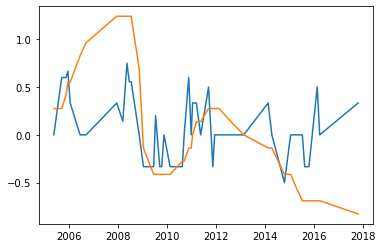

In [ ]:
#Scaler
# MaxAbsScaler RobustScaler StandardScaler MinMaxScaler
import pandas as pd
from sklearn import preprocessing
x = final_tone['rate'].values.reshape(-1, 1) #returns a numpy array
scaler = preprocessing.RobustScaler()
x_scaled = scaler.fit_transform(x)
final_tone['rate'] = x_scaled

import matplotlib.pyplot as plt
plt.plot(final_tone[(final_tone['tone'] != 1) & (final_tone['tone'] != -1)]['tone'])
plt.plot(final_tone[(final_tone['tone'] != 1) & (final_tone['tone'] != -1)]['rate'])
plt.show()

In [ ]:
-

SyntaxError: invalid syntax (<ipython-input-49-60215a10e730>, line 1)

In [ ]:
#  데이터 부르기
test_data = pd.read_json(r'C:\Users\dhsmi\Downloads\test_ngram_datas.json')
test_data['ngram'] = list(map(lambda i : i.split(','), test_data['ngram']))
test_data['date'] = list(map(lambda i : i.date(), test_data['date']))
test_data = test_data[test_data['date']<= datetime.date(2017,12,31)]
test_data

In [ ]:
test_data = pd.read_json(r'C:\Users\dhsmi\Downloads\test_ngram_datas.json')
test_data['ngram'] = list(map(lambda i : i.split(','), test_data['ngram']))
test_data['date'] = list(map(lambda i : i.date(), test_data['date']))
test_data = test_data[test_data['date']<= datetime.date(2017,12,31)]
# hawkish, dovish 사전 필요
# 0으로 나눠지는 값의 의미 = hawkish, dovish 사전에 아예 없음을 의미함
# 해당 부분은 드랍하는 것이 맞을 듯

def tone_sent(x):
    a = 0
    b = 0
    for ngram in x:
        if ngram in hawkish:
            a += 1
        elif ngram in dovish:
            b += 1
    try:
        return (a-b) / (a+b)
    except:
        return np.nan
test_data['tone'] = list(map(tone_sent, test_data['ngram']))
test_data.dropna(inplace=True)
# 0은 중립
test_data['HD'] = list(map(lambda i : 'H' if i > 0 else 'D' if i < 0 else np.nan, test_data['tone']))
test_data.dropna(inplace=True)
test_data['H'] = list(map(lambda i : 1 if i == 'H' else 0, test_data['HD']))
test_data['D'] = list(map(lambda i : 1 if i == 'D' else 0, test_data['HD']))
final_tone = test_data.groupby('date').sum()[['H','D']]
final_tone['tone'] = (final_tone['H'] - final_tone['D']) / (final_tone['H'] + final_tone['D'])
sr_df = pd.read_json('standard_rate.json').set_index('date')
final_tone['rate'] = sr_df['rate']
corr = final_tone[['tone','rate']].corr(method = 'pearson')
print(corr)
import matplotlib.pyplot as plt
plt.plot(final_tone['tone'])
def norm(x):
    if x - final_tone['rate'].mean() > 0:
        (x - final_tone['rate'].mean()) / (final_tone['rate'].max() - final_tone['rate'].mean())
    else:
        (x - final_tone['rate'].mean()) / (final_tone['rate'].mean() - final_tone['rate'].min())
final_tone['norm_rate'] = list(map(norm, final_tone['rate']))
plt.plot(final_tone['norm_rate'])
plt.show()



In [ ]:
# ngram, ud 뽑

In [ ]:
# 클래스 호출
ncb = NBC()
# date = nbc
# datatransformser 써서 데이터변경 

In [ ]:
# 의사록 데이터
test_data = pd.read_json(r'C:\Users\student\Desktop\newsdata\test_ngram_datas.json')


test_data['ngram'] = list(map(lambda i : i.split(','), test_data['ngram']))
test_data['date'] = list(map(lambda i : i.date(), test_data['date']))
test_data = test_data[test_data['date']<= datetime.date(2017,12,31)]
# hawkish, dovish 사전 필요
# 0으로 나눠지는 값의 의미 = hawkish, dovish 사전에 아예 없음을 의미함
# 해당 부분은 드랍하는 것이 맞을 듯
def tone_sent(x):
    a = 0
    b = 0
    for ngram in x:
        if ngram in ppp[ppp['avg_score']>1.3].index:
            a += 1
        elif ngram in ppp[ppp['avg_score']<(10/13)].index:
            b += 1
    try:
        return (a-b) / (a+b)
    except:
        return np.nan
test_data['tone'] = list(map(tone_sent, test_data['ngram']))
test_data.dropna(inplace=True)
# 0은 중립
test_data['HD'] = list(map(lambda i : 'H' if i > 0 else 'D' if i < 0 else np.nan, test_data['tone']))
test_data.dropna(inplace=True)
test_data['H'] = list(map(lambda i : 1 if i == 'H' else 0, test_data['HD']))
test_data['D'] = list(map(lambda i : 1 if i == 'D' else 0, test_data['HD']))
final_tone = test_data.groupby('date').sum()[['H','D']]
final_tone['tone'] = (final_tone['H'] - final_tone['D']) / (final_tone['H'] + final_tone['D'])
sr_df = pd.read_json(r'C:\Users\student\Desktop\newsdata\rate\standard_rate.json').set_index('date')
final_tone['rate'] = sr_df['rate']
corr = final_tone[['tone','rate']].corr(method = 'pearson')
print(corr)
import matplotlib.pyplot as plt
plt.plot(final_tone['tone'])
def norm(x):
    if x - final_tone['rate'].mean() > 0:
        (x - final_tone['rate'].mean()) / (final_tone['rate'].max() - final_tone['rate'].mean())
    else:
        (x - final_tone['rate'].mean()) / (final_tone['rate'].mean() - final_tone['rate'].min())
final_tone['norm_rate'] = list(map(norm, final_tone['rate']))
plt.plot(final_tone['norm_rate'])
plt.show()